In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from subprocess import check_output
import matplotlib.pyplot as plt
import networkx as nx
from scipy import stats
# import squarify as sq
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
import sklearn
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
# Models to be used, all from sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB,BernoulliNB
from sklearn.svm import LinearSVC, SVC
from sklearn import metrics
# Transformers
from scipy.optimize import curve_fit
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import pairwise_distances
from six import StringIO

# For comparing metrics
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import confusion_matrix, classification_report
%matplotlib inline

## **1. First lets analyze how artists and genre are related by using network graphs**

**Graph**


In [ ]:
data = pd.read_csv("/content/music/Spotify-2000.csv")
data.head()

,Index,Title,Artist,Top Genre,Year,Beats Per Minute (BPM),Energy,Danceability,Loudness (dB),Liveness,Valence,Length (Duration),Acousticness,Speechiness,Popularity
0,1,Sunrise,Norah Jones,adult standards,2004,157,30,53,-14,11,68,201,94,3,71
1,2,Black Night,Deep Purple,album rock,2000,135,79,50,-11,17,81,207,17,7,39
2,3,Clint Eastwood,Gorillaz,alternative hip hop,2001,168,69,66,-9,7,52,341,2,17,69
3,4,The Pretender,Foo Fighters,alternative metal,2007,173,96,43,-4,3,37,269,0,4,76
4,5,Waitin' On A Sunny Day,Bruce Springsteen,classic rock,2002,106,82,58,-5,10,87,256,1,3,59


In [ ]:
g = nx.Graph()
g = nx.from_pandas_edgelist(data,source='Artist',target='Top Genre')
print(nx.info(g))


Graph with 880 nodes and 731 edges


In [ ]:
lead_artists = data.groupby('Top Genre')['Popularity'].sum().sort_values(ascending=False).head(20)
print(lead_artists)

Top Genre
album rock           25067
adult standards       7697
alternative rock      5757
dance pop             5687
alternative metal     4621
dutch pop             3981
modern rock           3361
pop                   3178
classic rock          3170
dance rock            3088
glam rock             2877
dutch indie           2795
permanent wave        2571
british invasion      2451
art rock              2408
dutch cabaret         2349
british soul          2058
irish rock            1982
europop               1531
glam metal            1223
Name: Popularity, dtype: int64


In [ ]:
plt.figure(figsize=(30, 40))
pos=nx.spring_layout(g, k=0.15)
nx.draw_networkx(g,pos,node_size=25, node_color='blue')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

## **2. Calculating number of songs in each genre**

In [ ]:
print(type(data['Top Genre']))
popular_genre=data.groupby('Top Genre').size().unique
print(popular_genre)
genre_list=data['Top Genre'].values.tolist()

<class 'pandas.core.series.Series'>
<bound method Series.unique of Top Genre
acid jazz             1
acoustic pop          4
adult standards     123
afropop               1
alaska indie          1
                   ... 
stomp and holler      1
streektaal            1
trance                1
uk pop                1
yacht rock            1
Length: 149, dtype: int64>


## **3.Calculating number of songs by each of artist**

In [ ]:
print(data.groupby('Artist').size())
popular_artist=data.groupby('Artist').size()
print(popular_artist)
artist_list=data['Artist'].values.tolist()

Artist
10cc             3
2Pac             3
3 Doors Down     2
3JS              1
4 Non Blondes    1
                ..
ZZ Top           3
Zucchero         1
a-ha             2
blink-182        1
Édith Piaf       1
Length: 731, dtype: int64
Artist
10cc             3
2Pac             3
3 Doors Down     2
3JS              1
4 Non Blondes    1
                ..
ZZ Top           3
Zucchero         1
a-ha             2
blink-182        1
Édith Piaf       1
Length: 731, dtype: int64


In [ ]:
data.isnull().sum()
data.fillna(0)

,Index,Title,Artist,Top Genre,Year,Beats Per Minute (BPM),Energy,Danceability,Loudness (dB),Liveness,Valence,Length (Duration),Acousticness,Speechiness,Popularity
0,1,Sunrise,Norah Jones,adult standards,2004,157,30,53,-14,11,68,201,94,3,71
1,2,Black Night,Deep Purple,album rock,2000,135,79,50,-11,17,81,207,17,7,39
2,3,Clint Eastwood,Gorillaz,alternative hip hop,2001,168,69,66,-9,7,52,341,2,17,69
3,4,The Pretender,Foo Fighters,alternative metal,2007,173,96,43,-4,3,37,269,0,4,76
4,5,Waitin' On A Sunny Day,Bruce Springsteen,classic rock,2002,106,82,58,-5,10,87,256,1,3,59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,1990,Heartbreak Hotel,Elvis Presley,adult standards,1958,94,21,70,-12,11,72,128,84,7,63
1990,1991,Hound Dog,Elvis Presley,adult standards,1958,175,76,36,-8,76,95,136,73,6,69
1991,1992,Johnny B. Goode,Chuck Berry,blues rock,1959,168,80,53,-9,31,97,162,74,7,74
1992,1993,Take Five,The Dave Brubeck Quartet,bebop,1959,174,26,45,-13,7,60,324,54,4,65


# Statistics

In [ ]:
pd.set_option('precision', 3)
data.describe()

,Index,Year,Beats Per Minute (BPM),Energy,Danceability,Loudness (dB),Liveness,Valence,Acousticness,Speechiness,Popularity
count,1994.000,1994.000,1994.000,1994.000,1994.000,1994.000,1994.000,1994.000,1994.000,1994.000,1994.000
mean,997.500,1992.993,120.216,59.680,53.238,-9.009,19.012,49.409,28.858,4.995,59.527
std,575.763,16.116,28.028,22.154,15.352,3.648,16.727,24.858,29.012,4.402,14.352
min,1.000,1956.000,37.000,3.000,10.000,-27.000,2.000,3.000,0.000,2.000,11.000
25%,499.250,1979.000,99.000,42.000,43.000,-11.000,9.000,29.000,3.000,3.000,49.250
50%,997.500,1993.000,119.000,61.000,53.000,-8.000,12.000,47.000,18.000,4.000,62.000
75%,1495.750,2007.000,136.000,78.000,64.000,-6.000,23.000,69.750,50.000,5.000,71.000
max,1994.000,2019.000,206.000,100.000,96.000,-2.000,99.000,99.000,99.000,55.000,100.000


Text(0.5, 1.0, 'Artist Name vs Count of songs')

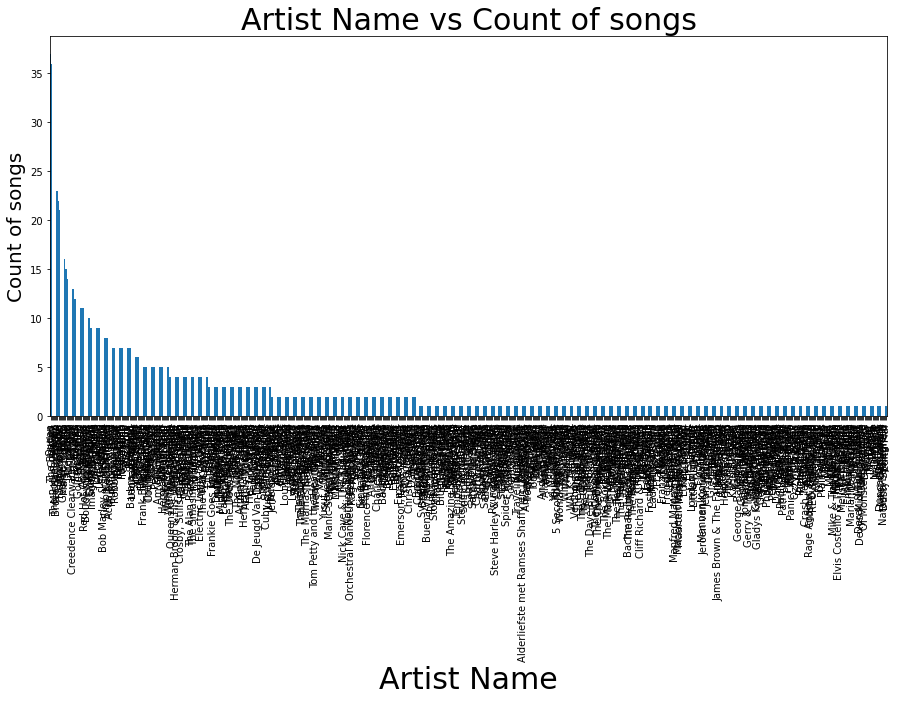

In [ ]:
fig = plt.figure(figsize = (15,7))
data.groupby('Artist')['Title'].agg(len).sort_values(ascending = False).plot(kind = 'bar')
plt.xlabel('Artist Name', fontsize = 30)
plt.ylabel('Count of songs', fontsize = 20)
plt.title('Artist Name vs Count of songs', fontsize = 30)

In [ ]:
data[data["Length (Duration)"].str.contains(",")==True]
data["Length (Duration)"] = data["Length (Duration)"].replace(["1,412","1,121","1,367","1,292"],['1412','1121','1367','1292'])
data["Length (Duration)"] = data["Length (Duration)"].astype(np.int64)

In [ ]:
data = data.drop(labels=['Index', 'Title'], axis=1)
data.shape

(1994, 13)

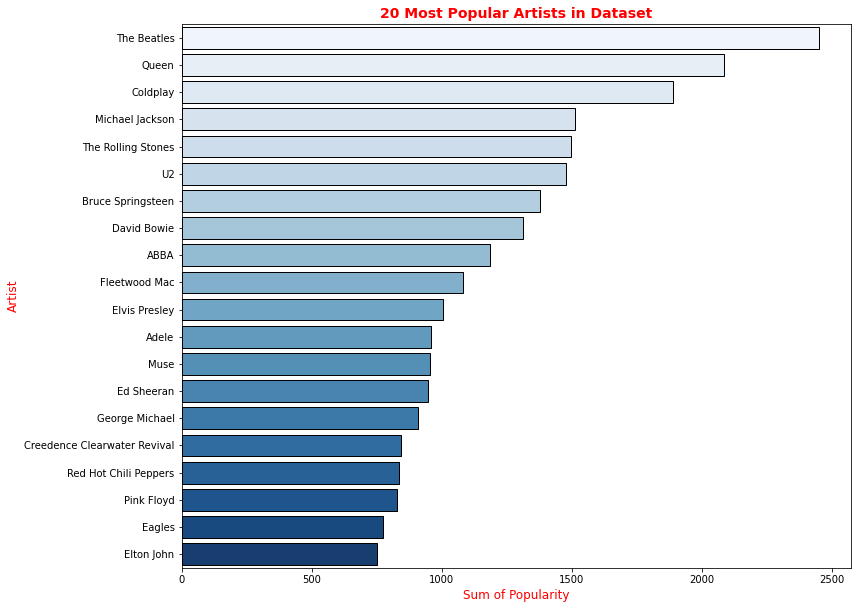

In [ ]:
fig, ax = plt.subplots(figsize = (12, 10))
lead_artists = data.groupby('Artist')['Popularity'].sum().sort_values(ascending=False).head(20)
ax = sns.barplot(x=lead_artists.values, y=lead_artists.index, palette="Blues", orient="h", edgecolor='black', ax=ax)
ax.set_xlabel('Sum of Popularity', c='r', fontsize=12)
ax.set_ylabel('Artist', c='r', fontsize=12)
ax.set_title('20 Most Popular Artists in Dataset', c='r', fontsize=14, weight = 'bold')
plt.show()

Well distributed, with obviously more popular music coming out from the 1970s onwards. It would be good to one day regress this data against the economic cycle. As expected, this distribution mirrors our findings with the artists' exploration. One can easily see where Beatles, Queen and Coldplay albums appear

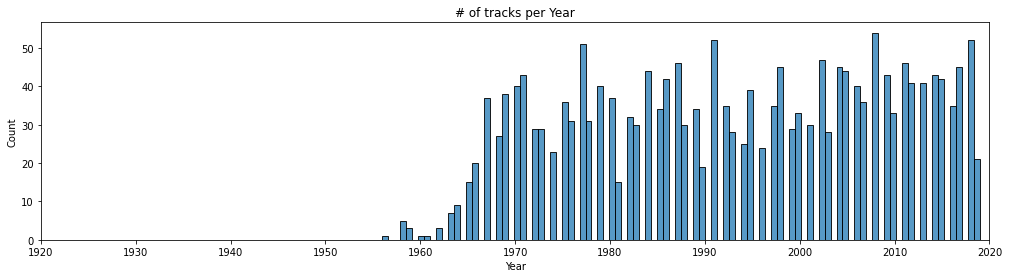

In [ ]:
fig, ax = plt.subplots(figsize=(17, 4))
ax = sns.histplot(data['Year'], bins = 100, kde = False)
ax.set_xlim(1920,2020)
ax.set_xticks(range(1920, 2021, 10))
ax.set_title('# of tracks per Year')
plt.show()


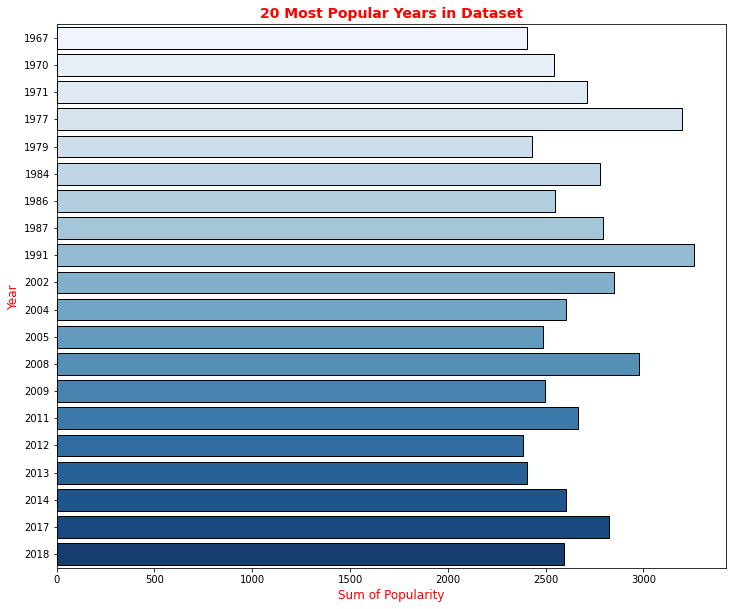

Text(0.5, 1.0, 'Year')

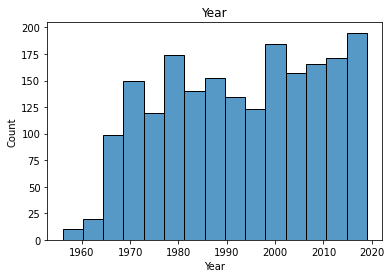

In [ ]:
fig, ax = plt.subplots(figsize = (12, 10))
lead_artists = data.groupby('Year')['Popularity'].sum().sort_values(ascending=False).head(20)
ax = sns.barplot(x=lead_artists.values, y=lead_artists.index, palette="Blues", orient="h", edgecolor='black', ax=ax)
ax.set_xlabel('Sum of Popularity', c='r', fontsize=12)
ax.set_ylabel('Year', c='r', fontsize=12)
ax.set_title('20 Most Popular Years in Dataset', c='r', fontsize=14, weight = 'bold')
plt.show()

#yearvise count of songs
sns.histplot(data['Year']).set_title('Year')

**Top Genre**

Upon exploration, this column was dropped due to poor explanatory data. A lot of Bruce Springsteen's greatest hits laballed as 'album rock' clouded the actual genres to explore. Without a secondary label, we could not relabel the songs in the 'album rock' category

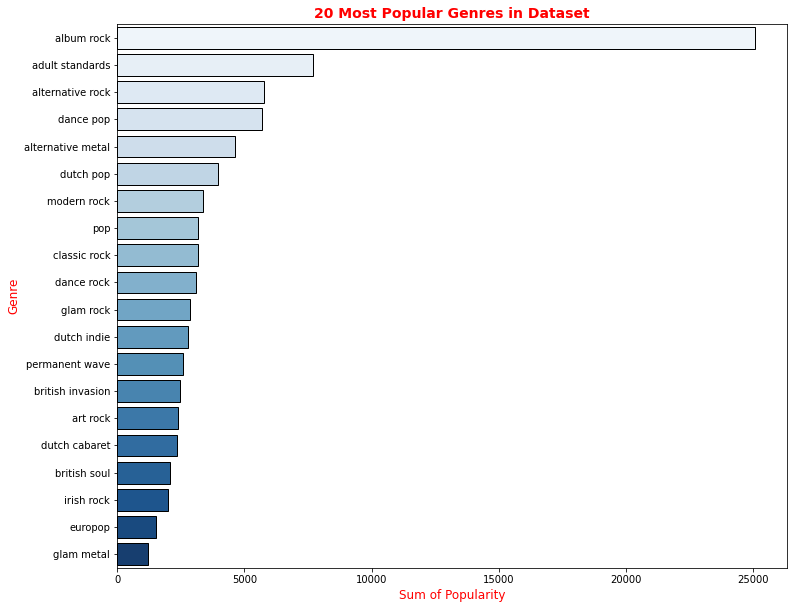

In [ ]:
fig, ax = plt.subplots(figsize = (12, 10))
lead_artists = data.groupby('Top Genre')['Popularity'].sum().sort_values(ascending=False).head(20)
ax = sns.barplot(x=lead_artists.values, y=lead_artists.index, palette="Blues", orient="h", edgecolor='black', ax=ax)
ax.set_xlabel('Sum of Popularity', c='r', fontsize=12)
ax.set_ylabel('Genre', c='r', fontsize=12)
ax.set_title('20 Most Popular Genres in Dataset', c='r', fontsize=14, weight = 'bold')
plt.show()

#**POPULARITY ANALYSIS AND PREDICTION**

**Every attribute's relation with popularity**


1.Beats per minute

Text(0.5, 1.0, 'Beats Per Minute (BPM)')

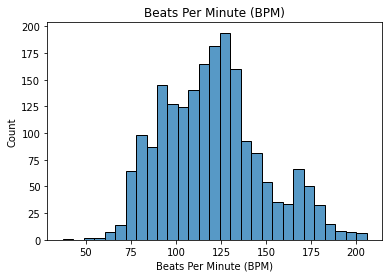

In [ ]:
sns.histplot(data['Beats Per Minute (BPM)']).set_title('Beats Per Minute (BPM)')


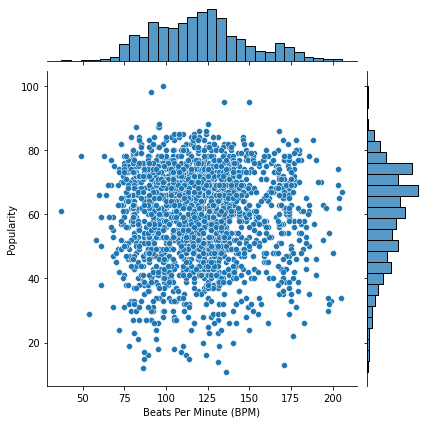

In [ ]:
sns.jointplot(x = 'Beats Per Minute (BPM)', y = 'Popularity', data = data)

2.Energy

Text(0.5, 1.0, 'Energy')

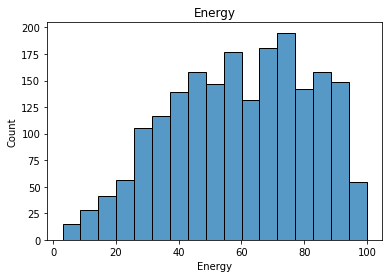

In [ ]:
sns.histplot(data['Energy']).set_title('Energy')

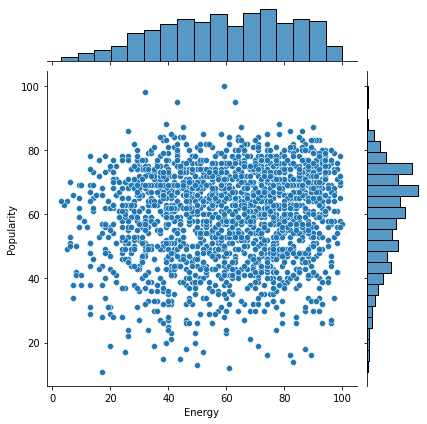

In [ ]:
sns.jointplot(x = 'Energy', y = 'Popularity', data = data)

3.Danceability

Text(0.5, 1.0, 'Danceability')

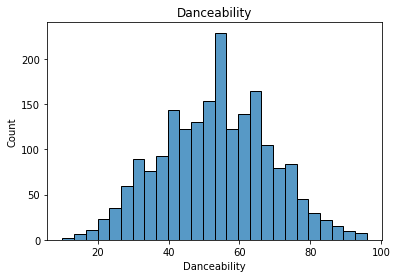

In [ ]:
sns.histplot(data['Danceability']).set_title('Danceability')

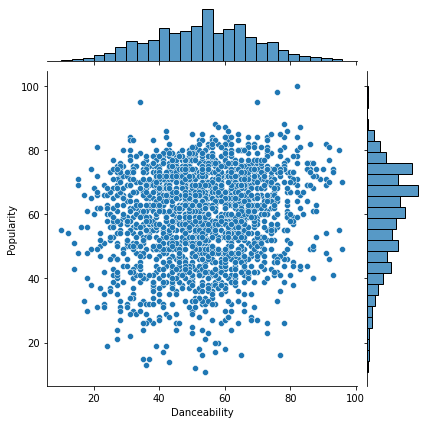

In [ ]:
sns.jointplot(x = 'Danceability', y = 'Popularity', data = data)

4.Loudness

Text(0.5, 1.0, 'Loudness (dB)')

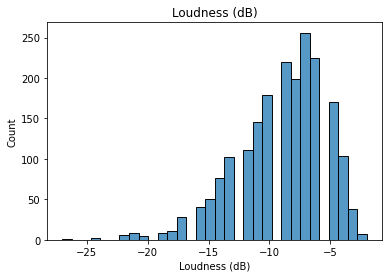

In [ ]:
sns.histplot(data['Loudness (dB)']).set_title('Loudness (dB)')

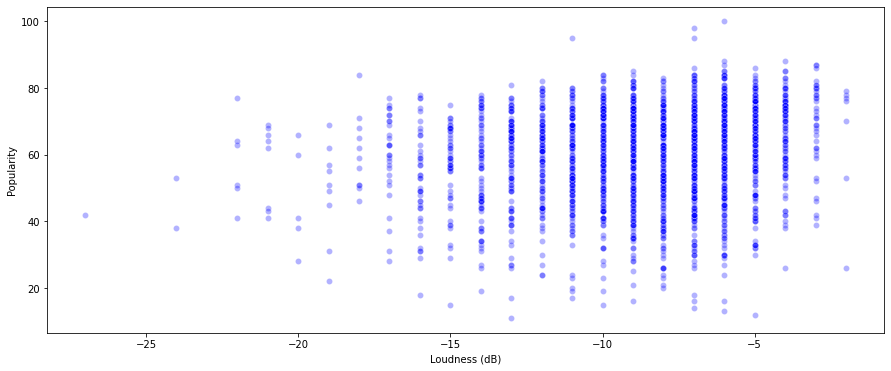

In [ ]:
fig, ax = plt.subplots(figsize = (15, 6))
sns.scatterplot(x='Loudness (dB)', y='Popularity', data=data, color='blue', alpha=0.3)
plt.show()

5.Liveness

Text(0.5, 1.0, 'Liveness')

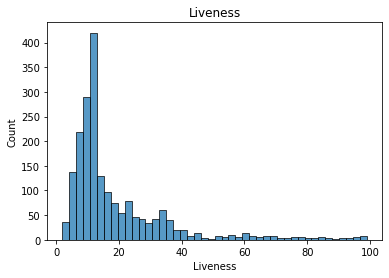

In [ ]:
#Most songs are not live...! What a surprise
sns.histplot(data['Liveness']).set_title('Liveness')

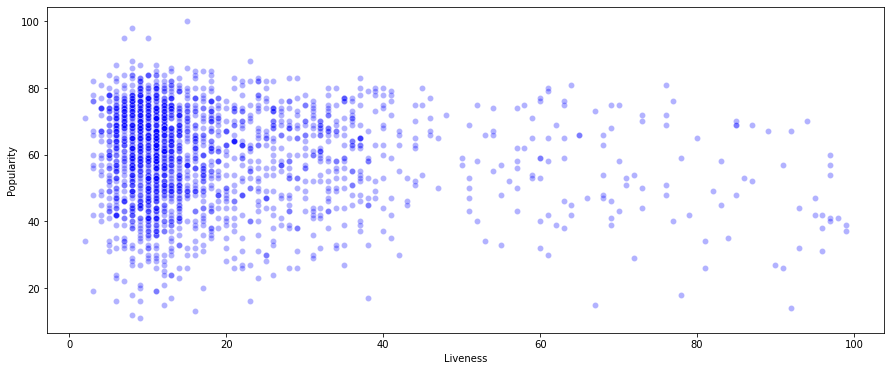

In [ ]:
fig, ax = plt.subplots(figsize = (15, 6))
sns.scatterplot(x='Liveness', y='Popularity', data=data, color='blue', alpha=0.3)
plt.show()

6.Valence

Text(0.5, 1.0, 'Valence')

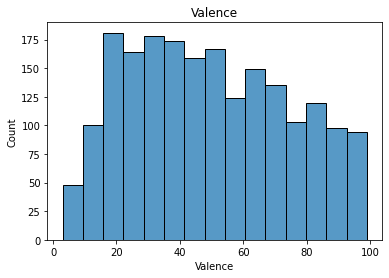

In [ ]:
sns.histplot(data['Valence']).set_title('Valence')

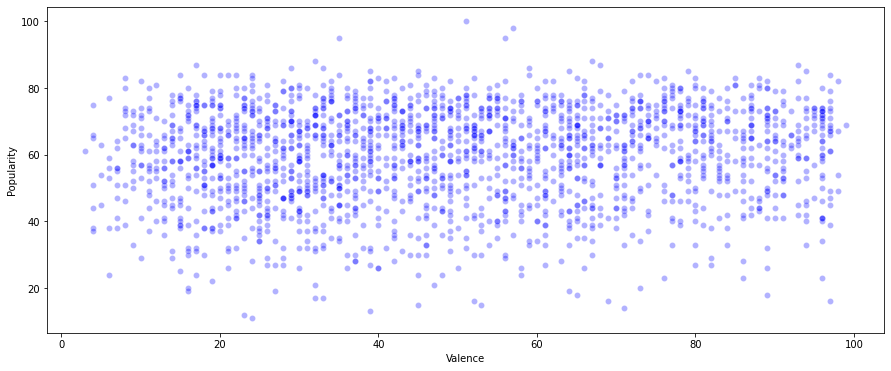

In [ ]:
fig, ax = plt.subplots(figsize = (15, 6))
sns.scatterplot(x='Valence', y='Popularity', data=data, color='blue', alpha=0.3)
plt.show()

7.Length

Text(0.5, 1.0, 'Length (Duration)')

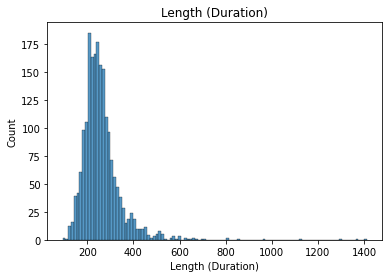

In [ ]:
sns.histplot(data['Length (Duration)']).set_title('Length (Duration)')

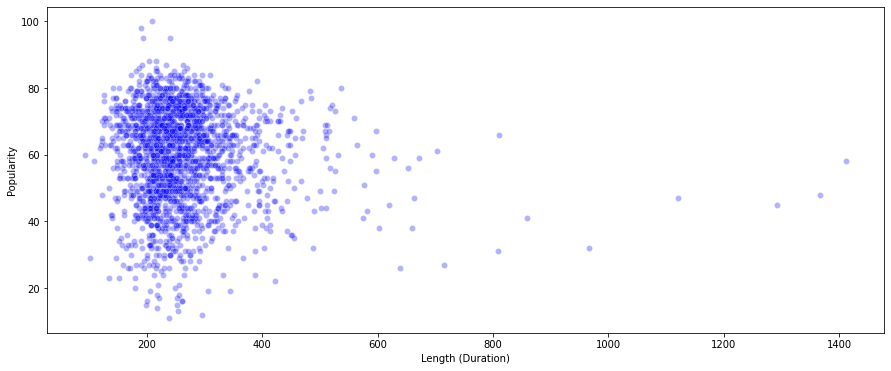

In [ ]:
fig, ax = plt.subplots(figsize = (15, 6))
sns.scatterplot(x='Length (Duration)', y='Popularity', data=data, color='blue', alpha=0.3)
plt.show()


8.Acousticness

Text(0.5, 1.0, 'Acousticness')

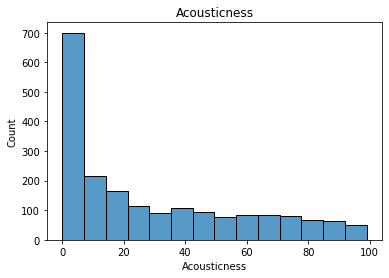

In [ ]:
sns.histplot(data['Acousticness']).set_title('Acousticness')

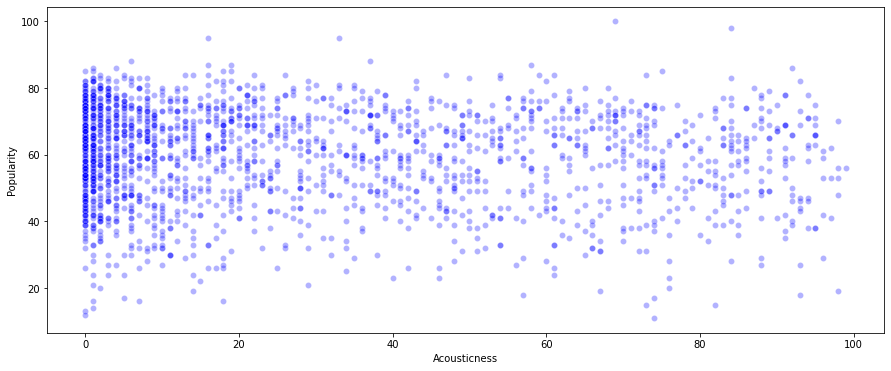

In [ ]:
fig, ax = plt.subplots(figsize = (15, 6))
sns.scatterplot(x='Acousticness', y='Popularity', data=data, color='blue', alpha=0.3)
plt.show()

9.Speechiness

Text(0.5, 1.0, 'Speechiness')

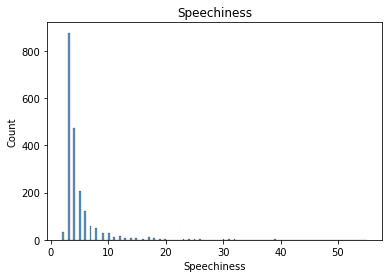

In [ ]:
sns.histplot(data['Speechiness']).set_title('Speechiness')

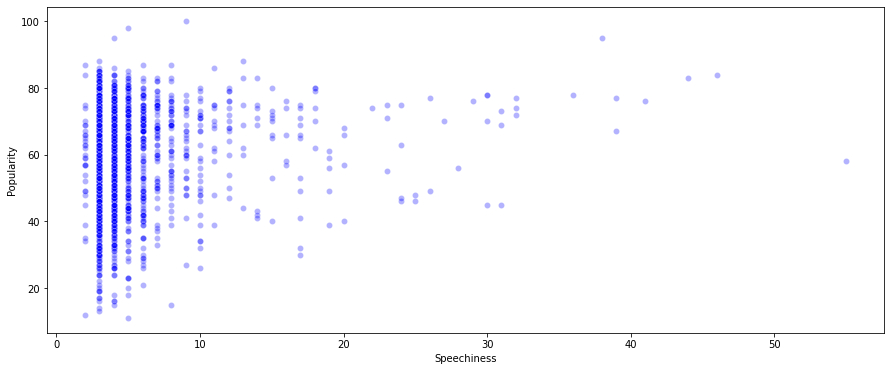

In [ ]:
fig, ax = plt.subplots(figsize = (15, 6))
sns.scatterplot(x='Speechiness', y='Popularity', data=data, color='blue', alpha=0.3)
plt.show()

**Prediction**

Target : Popularity

In [ ]:
data['Popularity'].describe()

count    1994.000
mean       59.527
std        14.352
min        11.000
25%        49.250
50%        62.000
75%        71.000
max       100.000
Name: Popularity, dtype: float64

Text(0.5, 1.0, 'Popularity Distribution')

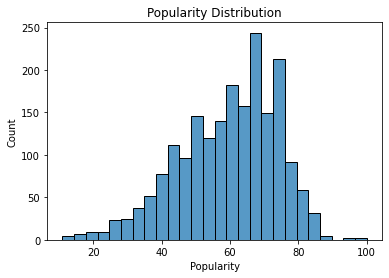

In [ ]:
sns.histplot(data['Popularity']).set_title('Popularity Distribution')

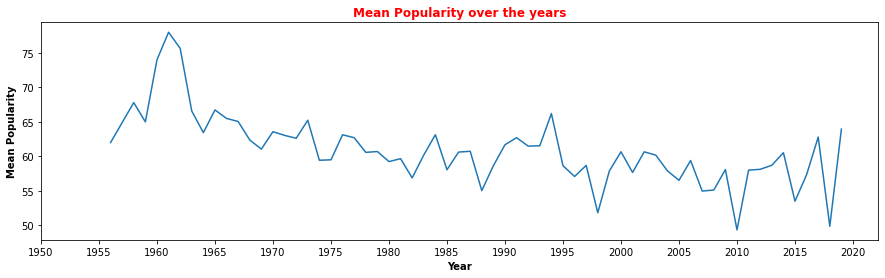

In [ ]:
fig, ax = plt.subplots(figsize=(15, 4))
ax = data.groupby('Year')['Popularity'].mean().plot()
ax.set_title('Mean Popularity over the years', c='r', weight='bold')
ax.set_ylabel('Mean Popularity', weight='bold')
ax.set_xlabel('Year', weight='bold')
ax.set_xticks(range(1950, 2021, 5))
plt.show()

**Splitting into Train and Test**

In [ ]:
#Linear regression, first create test and train dataset
x=data.loc[:,['Energy','Danceability','Length (Duration)','Loudness (dB)','Acousticness']].values
y=data.loc[:,'Popularity'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.30)

In [ ]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)
print(regressor.intercept_)
print(regressor.coef_)

64.71726792068776
[-0.05685767  0.12682815 -0.00412315  0.7965644  -0.01295848]


In [ ]:
#Displaying the difference between the actual and the predicted
y_pred = regressor.predict(X_test)
data_output = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(data_output)

     Actual  Predicted
0        60     59.596
1        55     66.044
2        56     63.274
3        33     64.761
4        28     58.505
..      ...        ...
594      53     57.130
595      46     57.746
596      66     60.628
597      68     55.061
598      51     58.125

[599 rows x 2 columns]


In [ ]:
#Checking the accuracy of Linear Regression
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 11.14121740689241
Mean Squared Error: 188.82271717236006
Root Mean Squared Error: 13.741277858058181


In [ ]:
log_model = LogisticRegression()
knn_model = KNeighborsClassifier()
dec_model = DecisionTreeClassifier()
rfc_model = RandomForestClassifier()


In [ ]:
log_model.fit(X_train, y_train)
knn_model.fit(X_train, y_train)
dec_model.fit(X_train, y_train)
rfc_model.fit(X_train, y_train)

lin_acc = regressor.score(X_test, y_test)
log_acc = log_model.score(X_test, y_test)
knn_acc = knn_model.score(X_test, y_test)
dec_acc = dec_model.score(X_test, y_test)
rfc_acc = rfc_model.score(X_test, y_test)

In [ ]:
print("Linear Regression Accuracy:", lin_acc)
print("Logistic Regression Accuracy:", log_acc)
print("K-Nearest-Neighbors Accuracy:", knn_acc)
print("Decision Tree Accuracy:", dec_acc)
print("Random Forest Classifier Accuracy:", rfc_acc)

Linear Regression Accuracy: 0.061185728577672016
Logistic Regression Accuracy: 0.025041736227045076
K-Nearest-Neighbors Accuracy: 0.011686143572621035
Decision Tree Accuracy: 0.015025041736227046
Random Forest Classifier Accuracy: 0.02337228714524207


In [ ]:
import plotly.express as px
fig = px.bar(
    x=["Linear Regression","Logistic Regression", "K-Nearest-Neighbors", "Decision Tree", "Random Forest Clasifier"],
    y=[lin_acc,log_acc, knn_acc, dec_acc, rfc_acc],
    color=["Linear Regression","Logistic Regression", "K-Nearest-Neighbors", "Decision Tree", "Random Forest Clasifier"],
    labels={'x': "Model", 'y': "Accuracy"},
    title="Model Accuracy Comparison"
)

fig.show()

### **Genre Prediction**


In [ ]:
x=data.loc[:,['Artist']].values
y=data.loc[:,'Top Genre'].values

In [ ]:
x.shape
encoder=LabelEncoder()
x = encoder.fit_transform(x)
x=pd.DataFrame(x)
x

In [ ]:
# Label Encoding of target
Encoder_y=LabelEncoder()
Y = Encoder_y.fit_transform(y)
Y=pd.DataFrame(Y)
Y

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.3,random_state = 1)

from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
sc.fit(x_train)
x_train=sc.transform(x_train)
x_test=sc.transform(x_test)

In [ ]:
# KNN Classification
# sorted(sklearn.neighbors.VALID_METRICS['brute'])
knn = KNeighborsClassifier(n_neighbors = 17)
knn.fit(x_train,y_train)
y_pred=knn.predict(x_test)

In [ ]:
df_output = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(df_output)

               Actual         Predicted
0     adult standards         dutch pop
1        british soul      classic rock
2          irish rock        irish rock
3     australian rock               pop
4          album rock        album rock
..                ...               ...
594  arkansas country  arkansas country
595               pop               pop
596  alternative rock  alternative rock
597        album rock        album rock
598         dance pop         dance pop

[599 rows x 2 columns]
